In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as crs

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import xesmf as xe
import optwrf as ow
from optwrf import runwrf as rw

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# The following function is an ad-hoc fix that changes out-of-original-grid values from zero to NaN.
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

In [3]:
param_ids = [8, 3, 7, 7, 7, 99]
start_date = 'Jul 26, 2011'
end_date = 'Jul 27, 2011'
wrf_sim = rw.WRFModel(param_ids, start_date, end_date, 
                      setup_yaml='/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/met4ene/optwrf/optwrf/data/mac_dirpath.yml') 

Forecast starting on: 2011-07-26 00:00:00
Forecast ending on: 2011-07-27 00:00:00


In [4]:
# Process the ERA5 data
wrf_sim.process_era5_data()

era_100wind: <xarray.Dataset>
Dimensions:    (Time: 744, latitude: 97, longitude: 129)
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * Time       (Time) datetime64[ns] 2011-07-01 ... 2011-07-31T23:00:00
Data variables:
    VAR_100U   (Time, latitude, longitude) float32 ...
    VAR_100V   (Time, latitude, longitude) float32 ...
era_out: <xarray.Dataset>
Dimensions:    (Time: 1104, latitude: 97, longitude: 129)
Coordinates:
  * Time       (Time) datetime64[ns] 2011-06-16T06:00:00 ... 2011-08-01T05:00:00
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
Data variables:
    VAR_100U   (Time, latitude, longitude) float32 nan nan nan ... nan nan nan
    VAR_100V   (Time, latitude, longitude) float32 nan nan nan ... nan nan nan
    WPD        (Time, latitude, long

In [5]:
# Find the path to optwrf
optwrf_path = os.path.dirname(os.path.abspath(inspect.getfile(ow)))

In [6]:
in_yr = wrf_sim.forecast_start.strftime('%Y')
in_mo = wrf_sim.forecast_start.strftime('%m')
in_da = wrf_sim.forecast_start.strftime('%d')
wrfdir = os.path.join(optwrf_path, 'data/')
eradir = wrf_sim.DIR_ERA5_ROOT

The xESMF regridder docs are located at: https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html

In [7]:
# WRF file containing source grid
wrffile = 'wrfout_processed_d01.nc'
try:
    wrfdata = xr.open_dataset(wrfdir + wrffile)
except FileNotFoundError:
    print(f'The wrfout file {wrfdir + wrffile} does not exist. Check that your path.')

# Get wrf variable(s) to regrid
# wrf_lat = wrfdata.XLAT
# wrf_lon = wrfdata.XLONG
# wrfdata = wrfdata.rename({'XLONG': 'lon', 'XLAT': 'lat'})

# Read in and convert GHI from W m-2 to kW m-2
ghi = wrfdata.ghi
ghi = ghi/1000

# Read in WPD, convert from W m-2 to kW m-2
wpd = wrfdata.wpd
wpd = wpd/1000

wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-07-26 ... 2011-07-26T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 6896.464 ... 20932...

In [8]:
# ERA data file(s)
erafile = f'ERA5_EastUS_WPD-GHI_{str(in_yr).zfill(4)}-{str(in_mo).zfill(2)}.nc'
try:
    eradata = xr.open_dataset(eradir + erafile)
except FileNotFoundError:
    print(f'The wrfout file {eradir + erafile} does not exist. Check that your path.')

eradata

<xarray.Dataset>
Dimensions:    (Time: 744, latitude: 97, longitude: 129)
Coordinates:
  * Time       (Time) datetime64[ns] 2011-07-01 ... 2011-07-31T23:00:00
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
Data variables:
    VAR_100U   (Time, latitude, longitude) float32 ...
    VAR_100V   (Time, latitude, longitude) float32 ...
    WPD        (Time, latitude, longitude) float32 ...
    SSRD       (Time, latitude, longitude) float32 ...
    GHI        (Time, latitude, longitude) float32 ...

In [9]:
# Get variables to compare with regridded WRF variables.
# era_lat = eradata.latitude
# era_lon = eradata.longitude
eradata = eradata.rename({'longitude': 'lon', 'latitude': 'lat'})

# Read in ERA_GHI, convert from W m-2 to kW m-2
era_ghi = eradata.GHI
era_ghi = era_ghi / 1000

# Read in ERA_WPD, convert from W m-2 to kW m-2
era_wpd = eradata.WPD
era_wpd = era_wpd / 1000

# Write these back to the xarray dataset
eradata['ghi'] = era_ghi
eradata['wpd'] = era_wpd
eradata

<xarray.Dataset>
Dimensions:   (Time: 744, lat: 97, lon: 129)
Coordinates:
  * Time      (Time) datetime64[ns] 2011-07-01 ... 2011-07-31T23:00:00
  * lat       (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
Data variables:
    VAR_100U  (Time, lat, lon) float32 ...
    VAR_100V  (Time, lat, lon) float32 ...
    WPD       (Time, lat, lon) float32 132772.75 176799.77 ... 9039.04 10462.853
    SSRD      (Time, lat, lon) float32 ...
    GHI       (Time, lat, lon) float32 42.133335 45.52889 ... 0.07111111
    ghi       (Time, lat, lon) float32 0.042133335 0.04552889 ... 7.111111e-05
    wpd       (Time, lat, lon) float32 132.77275 176.79976 ... 10.4628525

In [10]:
# Do the regridding
regridder = xe.Regridder(wrfdata, eradata, 'bilinear')
regridder = add_matrix_NaNs(regridder)
wrf_ghi_regrid = regridder(ghi)
wrf_wpd_regrid = regridder(wpd)
# wrf_ghi_regrid = xe.rcm2rgrid(wrf_lat, wrf_lon, ghi, era_lat, era_lon)
# wrf_wpd_regrid = xe.rcm2rgrid(wrf_lat, wrf_lon, wpd, era_lat, era_lon)

/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [11]:
# Add the regridded variables to the WRF xarray dataset
wrfdata['ghi_regrid'] = wrf_ghi_regrid
wrfdata['wpd_regrid'] = wrf_wpd_regrid

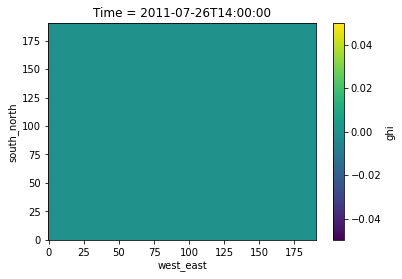

In [12]:
ghi2d = wrfdata.ghi.isel(Time=14)
ghi2d.plot()

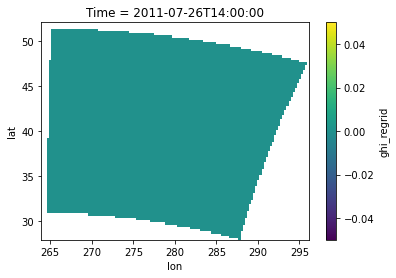

In [13]:
ghi2d = wrfdata.ghi_regrid.isel(Time=14)
ghi2d.plot()

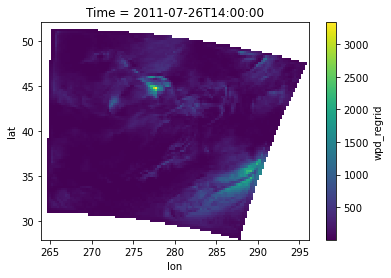

In [14]:
wrf_wpd_regrid
wpd2d = wrfdata.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [15]:
# Now test the function that does the same as the above in optwrf.runwrf
wrfdata_2, eradata_2 = rw.wrf_era5_regrid_xesmf(in_yr, in_mo, wrfdir, eradir)

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


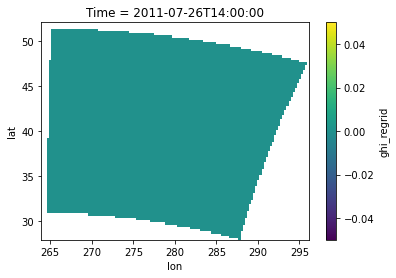

In [16]:
ghi2d = wrfdata_2.ghi_regrid.isel(Time=14)
ghi2d.plot()

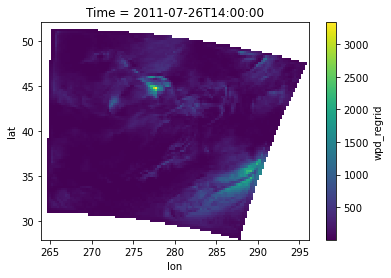

In [17]:
wrf_wpd_regrid
wpd2d = wrfdata_2.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [18]:
eradata_2

<xarray.Dataset>
Dimensions:   (Time: 744, lat: 97, lon: 129)
Coordinates:
  * Time      (Time) datetime64[ns] 2011-07-01 ... 2011-07-31T23:00:00
  * lat       (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
Data variables:
    VAR_100U  (Time, lat, lon) float32 ...
    VAR_100V  (Time, lat, lon) float32 ...
    WPD       (Time, lat, lon) float32 132772.75 176799.77 ... 9039.04 10462.853
    SSRD      (Time, lat, lon) float32 ...
    GHI       (Time, lat, lon) float32 42.133335 45.52889 ... 0.07111111
    ghi       (Time, lat, lon) float32 0.042133335 0.04552889 ... 7.111111e-05
    wpd       (Time, lat, lon) float32 132.77275 176.79976 ... 10.4628525

In [19]:
wrfdata_2

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-07-26 ... 2011-07-26T23:00:00
  * lon             (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat             (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 6896.464 ... 20932...
    ghi_regrid      (Time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    wpd_regrid      (Time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [20]:
wpd_error = abs(wrfdata_2.wpd_regrid - eradata_2.wpd)
wpd_error[0,0,:50]

<xarray.DataArray (lon: 50)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    Time     datetime64[ns] 2011-07-26
  * lon      (lon) float64 264.0 264.2 264.5 264.8 ... 275.5 275.8 276.0 276.2
    lat      float64 52.0

In [21]:
# To get around xrray nan bug, fill all nan with -1 (since we took the abs(), all the values in our GHI error should be >= 0)
wpd_error_nonan = wpd_error.fillna(-1)
wpd_error_nonan[0,0,:50]

<xarray.DataArray (lon: 50)>
array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
Coordinates:
    Time     datetime64[ns] 2011-07-26
  * lon      (lon) float64 264.0 264.2 264.5 264.8 ... 275.5 275.8 276.0 276.2
    lat      float64 52.0

In [22]:
total_wpd_error = wpd_error_nonan.sum(dim='Time')
total_wpd_error = total_wpd_error.where(total_wpd_error > 0)
total_wpd_error

<xarray.DataArray (lat: 97, lon: 129)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * lat      (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0

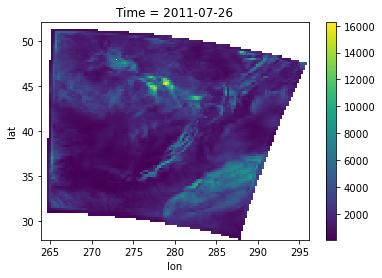

In [23]:
# Manually calculate the sum to make sure that they are the same
for ii in range (0, 24):
    if ii == 0:
        total_wpd_error_man = wpd_error.isel(Time=ii) 
    else:
        total_wpd_error_man += wpd_error.isel(Time=ii) 
total_wpd_error_man.plot()

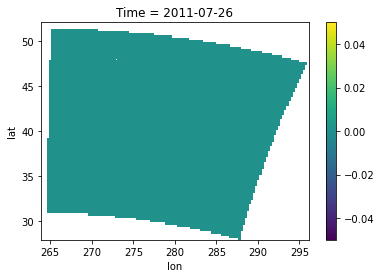

In [24]:
# Compare the manual and hacky bug fix. (All should be nan or 0)
diff = total_wpd_error_man - total_wpd_error_man
diff.plot()

In [25]:
print(f'The difference between the two is: {diff.sum().values}')
print(f'The total WPD error as calculated by the hacky fix: {float(total_wpd_error.sum().values)}')
print(f'The total WPD error as calculated manually: {float(total_wpd_error_man.sum().values)}')

The difference between the two is: 0.0
The total WPD error as calculated by the hacky fix: 17314087.129432835
The total WPD error as calculated manually: 17308532.802384213


In [26]:
# Get the total error now using the function in optwrf.runwrf
wrfdata_2 = rw.wrf_era5_error(wrfdata_2, eradata_2)
wrfdata_2

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-07-26 ... 2011-07-26T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] 2011-07-26 ... 2011-07-26T23:00:00
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 6896.464 ... 2093...
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [27]:
error = [0, float(wrfdata_2['total_ghi_error'].sum().values), float(wrfdata_2['total_wpd_error'].sum().values)]
error

[0, 52013.32785676392, 17314087.129432835]